In [1]:
# Import required packages
from time_functions import *
import calendar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import statsmodels.api
from statsmodels.stats import anova
from statsmodels.formula import api
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=RuntimeWarning)
sns.set_style('white')

> *Von Süda bis doa <br>
> A Dach’has schwebd über ons <br>
> Malde isch so schee*

## Introduction
The analysis presented in the following paragraphs is based on training data of the year 2022 from an athlete studying in the Management & Data Science Master program at Leuphana university. In every training session, training data was gathered using a smartwatch. The training types include running, yoga, weight training and crosstraining. As the athlete is a competitive runner, the aerobic training effect (ATE) is of particular interest as it indicated progress in the key athletic skills required for peak performance in races.

The following research questions are addressed:
- Question 1: When were certain activities performed?
- Question 2: How do training types differ in performance parameters?
- Question 3: How can running activities be clustered?
- Question 4: How is the aerobic training effect explained by other training parameters?

After the initial loading and preprocessing of the data, question 1 is adressed using histograms. Following, to answer question 2, a row of one-way ANOVAs are conducted. Question 3 is approached with a combined approach using principal component (PCA) and cluster analysis. Lastly, to answer question 4, a generalized linear model (GLM) is developed and different model reduction approaches are applied.


The most relevant features include:

- Activity type: The type of the activity
- Distance: The distance of the activity in km (if recorded for the activity)
- Time: The time of the activity
- Calories: The calories burned during the activity
- Avg. heart rate: The average heart rate during the activity
- Max. heart rate: The maximum heart rate during the activity
- Avg. pace: The average pace during the activity (if recorded for the activity)
- Aerobic TE: The aerobic training effect of the activity, which measures the training load of the activity


## Preprocessing

> *Aerober TE <br>
Den Nils um Hilfe bitten <br>
Leerzeichen sind Schmutz*

The first step is to load and preprocess the data, in order to make it ready for further analysis. To do so, an iterative approach is used, where the data is repeatedly
inspected and cleaned / adjusted, until no further changes are necessary. The preprocessing includes dropping irrelevant columns, transforming the date columns, replacing
the -- values with NaN, renaming the columns, and transforming the time columns to numeric values in minutes. Furthermore, zero values in the heart rate columns are replaced
with NaN, as this is not possible. Besides that, the data is limited to the most relevant activities. This is done, as all types of analysis based on a real small number of
samples are not meaningful. Finally, a subsample containing only running activities is created for further analysis on the running activities.

In [2]:
def load_and_preprocess_dataset(path: str) -> pd.DataFrame:
    # Load the original dataset
    df = pd.read_csv(path, encoding='utf8')

    # Drop all irrelevant columns
    potential_drops = ['Durchschnittliches vertikales Verhältnis', 'Ø vertikale Bewegung', 'Ø Bodenkontaktzeit',
                       'Training Stress Score®', 'Ø Leistung', 'Max. Leistung', 'Grit', 'Flow', 'Ø Swolf',
                       'Ø Schlagrate', 'Tauchzeit', 'Oberflächenpause', 'Dekompression', 'Favorit', 'Titel',
                       'Zeit in Bewegung', 'Verstrichene Zeit', 'Beste Rundenzeit', 'Wiederholungen insgesamt',
                       'Sätze insgesamt']
    df.drop(columns=[c for c in potential_drops if c in df.columns],inplace=True)

    # Transform data date columns and add a new column for the time
    df.Datum = pd.to_datetime(df.Datum)
    df.insert(loc=2, column='Start Time', value=df['Datum'].dt.time)

    # Replace all -- values with NaN
    df.replace('--', np.nan, inplace=True)

    # Rename different types of running activities to 'Laufen'
    df.loc[df['Aktivitätstyp'].isin(['Indoor-Laufen', 'Laufbandtraining']), 'Aktivitätstyp'] = 'Laufen'

    # Transform the time column to numeric values in minutes
    for col in ['Zeit', 'Ø Pace', 'Beste Pace']:
        df[col] = df[col].astype(str).apply(lambda t: from_text_to_numeric(time=t, output='m'))


    # Try to transform all columns to numeric datatype
    for col in df.columns:
        try:
            df[col] = df[col].astype(str).str.replace(',', '').astype(float)
        except:
            pass

    # Rename the columns to replace the Ø sign with Avg
    df.columns = [c.replace('Ø ', 'Avg_').replace(' ', '_') for c in df.columns]

    # Replace 0.0 values in the Avg_Herzfrequenz column with NaN as this is not possible
    df.loc[df['Avg_Herzfrequenz'] == 0.0, 'Avg_Herzfrequenz'] = np.nan

    # Return the DataFrame
    return df

# Show first and last 5 rows
data = load_and_preprocess_dataset('Activities_2022_Cleaned.csv')
pd.concat([data.head(), data.tail()])

,Aktivitätstyp,Datum,Start_Time,Distanz,Kalorien,Zeit,Avg_Herzfrequenz,Maximale_Herzfrequenz,Aerober_TE,Avg_Schrittfrequenz_(Laufen),...,Maximale_Temperatur,Avg_Atemfrequenz,Minimale_Atemfrequenz,Maximale_Atemfrequenz,Stressänderung,Stress:_Start,Stress:_Ende,Avg_Stress,Minimale_Höhe,Maximale_Höhe
0,Laufen,2022-12-31 12:58:11,12:58:11,5.00,346.0,25.133333,149.0,171.0,2.2,169.0,...,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-43.0,-32.0
1,Laufen,2022-12-31 12:15:08,12:15:08,4.97,309.0,16.500000,184.0,192.0,3.2,180.0,...,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.0,1.0
2,Laufen,2022-12-31 11:28:19,11:28:19,5.00,351.0,24.150000,154.0,177.0,2.4,167.0,...,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-42.0,-33.0
3,Yoga,2022-12-30 17:40:14,17:40:14,NaN,84.0,47.566667,69.0,88.0,0.0,NaN,...,30.0,21.0,12.0,24.0,-40.0,60.0,20.0,30.0,NaN,NaN
4,Laufen,2022-12-30 13:21:52,13:21:52,12.05,786.0,56.450000,148.0,157.0,2.8,168.0,...,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,48.0
674,Laufen,2022-01-04 13:29:51,13:29:51,12.50,815.0,66.133333,146.0,182.0,3.0,151.0,...,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.0,53.0
675,Yoga,2022-01-03 20:14:01,20:14:01,NaN,58.0,37.433333,66.0,83.0,0.0,NaN,...,30.0,14.0,7.0,23.0,13.0,12.0,25.0,24.0,NaN,NaN
676,Laufen,2022-01-03 14:23:36,14:23:36,8.00,505.0,38.616667,142.0,150.0,2.4,166.0,...,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,28.0
677,Laufen,2022-01-02 14:20:31,14:20:31,16.80,1095.0,71.633333,158.0,171.0,3.6,165.0,...,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,51.0
678,Laufen,2022-01-01 14:23:42,14:23:42,12.03,756.0,49.000000,161.0,184.0,3.6,170.0,...,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,34.0


In [3]:
# rename column Aktivitätstyp to Activity
data.rename(columns={'Aktivitätstyp': 'Activity'}, inplace=True)


In [4]:
# change all values including Laufen in the 'Aktivitätstyp' column to running 
data.loc[data['Activity'].isin(['Laufen']), 'Activity'] = 'Running'
data.loc[data['Activity'].isin(['Krafttraining']), 'Activity'] = 'Strength Training'
data.loc[data['Activity'].isin(['Crosstraining']), 'Activity'] = 'Cross Training'


In [5]:
data['Activity'].value_counts()

Running              355
Yoga                 181
Strength Training     91
Cross Training        43
Radfahren              3
Atemübung              2
Cardio                 2
Indoor Cycling         1
Gehen                  1
Name: Activity, dtype: int64

In [6]:
data = data[data['Activity'].isin(['Running', 'Yoga', 'Strength Training', 'Cross Training'])]

In [7]:
# Take a subsample including only running activities and select numeric datatypes only
running_data = data[data.Activity == 'Running'].select_dtypes(include=np.number).drop(columns=['Avg_Atemfrequenz', 'Maximale_Atemfrequenz', 'Minimale_Atemfrequenz',
                                                                                                   'Stressänderung', 'Stress:_Start', 'Stress:_Ende', 'Avg_Stress']).dropna()
running_data_std = pd.DataFrame(StandardScaler().fit_transform(running_data), columns=running_data.columns, index=running_data.index)
# rename columns from running_data_std to English
running_data_std.rename(columns={'Distanz': 'Distance', 'Kalorien': 'Calories', 'Zeit': 'Time', 'Avg_Herzfrequenz' : 'Avg_heart_rate', 'Aerober_TE': 'Aerobic_training_effect', 'Maximale_Herzfrequenz': 'Max_Heart_Rate', 'Avg_Schrittfrequenz_(Laufen)': 'Avg_Step_Frequency', 'Max._Schrittfrequenz_(Laufen)': 'Max_Step_Frequency', 'Beste_Pace': 'Max_Pace', 
                                 'Anstieg_gesamt': 'Total_Ascent', 'Abstieg_gesamt': 'Total_Descent', 'Avg_Schrittlänge': 'Avg_Step_Length', 'Minimale_Temperatur': 'Min_Temperature', 'Anzahl_der_Runden': 'No_of_Rounds', 'Maximale_Temperatur': 'Max_Temperature', 'Minimale_Höhe': 'Min_Height', 'Maximale_Höhe': 'Max_Height'}, inplace=True)
# rename columns to English
data.rename(columns={'Kalorien': 'Calories'}, inplace=True)
data.rename(columns={'Zeit': 'Time'}, inplace=True)
data.rename(columns={'Avg_Herzfrequenz': 'Avg_heart_rate'}, inplace=True)
data.rename(columns={'Aerober_TE': 'Aerobic_training_effect'}, inplace=True)

## Question 1: When were certain activities performed?

In this section, the data is explored in order to get a better understanding of the data and to answer the first research questions. To do so, the approach is shortly described
and the results as well as reasoning are presented.

### At which time of the day did the athlete train? 

To answer this question, the start time of the activities is plotted as a histogram. The results show that running activities
have three peaks, while the other activities have only one peak. The three peaks of the running activities are in the morning, shortly after lunch and the late afternoon. Yoga is mainly
performed in the evening, while cross-training and strength training have a higher overlap within the late afternoon and evening. Overall, one can say that the activities follow a fix
pattern and that athletes follow a daily routine.

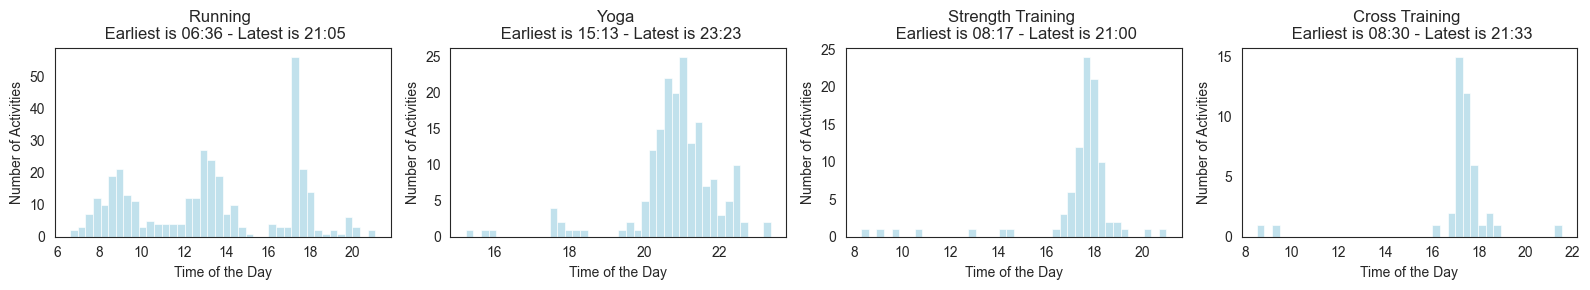

In [8]:
activities = data['Activity'].unique()

fig, axs = plt.subplots(1, 4, tight_layout=True, figsize=(16, 3))
axs = axs.flatten()
for i, activity in enumerate(activities):
    values = data.query(f'Activity == "{activity}"')['Start_Time'].astype(str).apply(lambda t: from_text_to_numeric(time=t, output='h'))
    sns.histplot(data=values, bins=40, ax=axs[i], color='lightblue')
    title = f'{activity} \n Earliest is {from_numeric_to_text(time=min(values), input_format="h", output="hh:mm")} - ' \
            f'Latest is {from_numeric_to_text(time=max(values), input_format="h", output="hh:mm")}'
    axs[i].set(xlabel='Time of the Day', ylabel='Number of Activities', title=title)

fig.show()

### How many kilometers were run per month?
To answer this question, the data is grouped by month and the sum of the distance is calculated. The results show that
the number of kilometers run per month fluctuates over the year. An increase in spring is visible, followed by a bit less kilometers in summer. In September the distance drops significantly, until
a fix level is reached in the winter months. The results show that the training is adapted to the racing season in summer. An intensive build-up phase in the spring is followed by races
in the summer with a subsequent season break before the build-up training starts again.

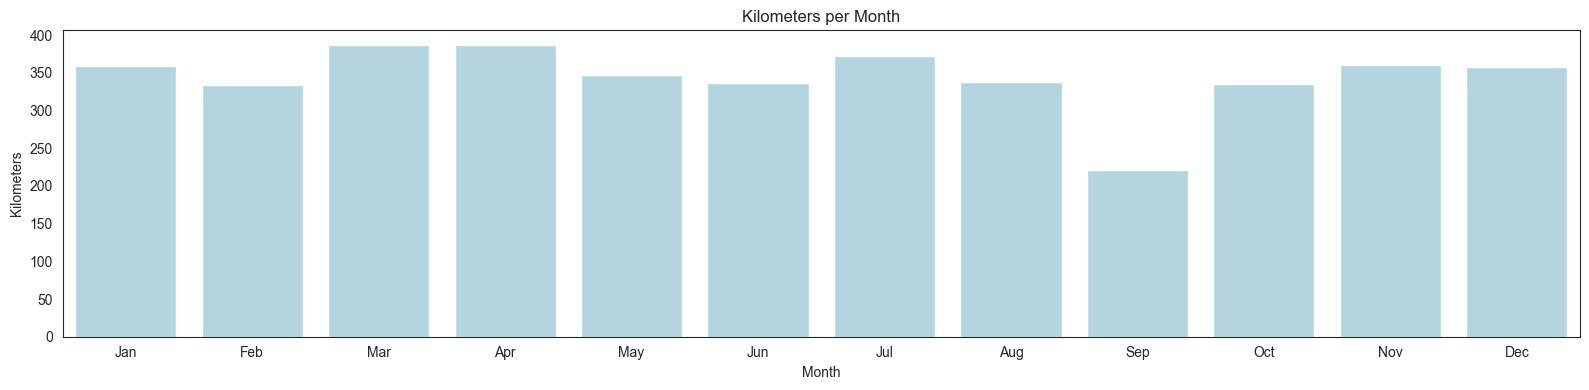

In [9]:
fig, ax = plt.subplots(tight_layout=True, figsize=(16, 4))
values = data[data['Activity'].isin(['Running', 'Indoor-Laufen', 'Laufbandtraining'])].groupby(data.Datum.dt.month)['Distanz'].sum()
sns.barplot(x=values.index, y=values.values, ax=ax, color='lightblue')
ax.set(title='Kilometers per Month', xlabel='Month', ylabel='Kilometers')
ax.set_xticklabels(list(calendar.month_abbr)[1:])
fig.show()

### How many kilometers were run per week?
The data is grouped by week and the sum of the distance is calculated and plotted. All across the
year the results show the pattern that the kilometers run increase over approximately three weeks before they drop for one week. This observation can be explained by the fact that distance
athletes follow a training plan based on the idea of increased training load over multiple weeks followed by a so-called deloading week to recover.

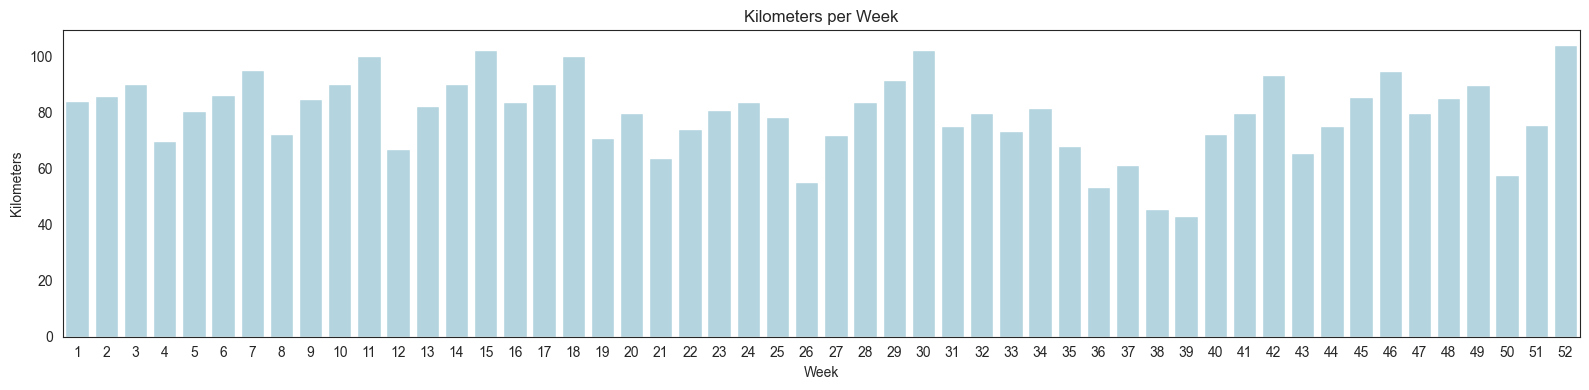

In [10]:
values = data[data['Activity'].isin(['Running', 'Indoor-Laufen', 'Laufbandtraining'])].groupby(data.Datum.dt.week)['Distanz'].sum()
fig, ax = plt.subplots(tight_layout=True, figsize=(16, 4))
sns.barplot(x=values.index, y=values.values, ax=ax, color='lightblue')
ax.set(title='Kilometers per Week', xlabel='Week', ylabel='Kilometers')
fig.show()

## Question 2: How do training types differ in performance parameters?
In the following section a [One-Way-Anova](https://sustainabilitymethods.org/index.php/ANOVA) is performed to check if there is a significant difference in the physiological measurements between the different activity types.
First, boxplots for the features calories, time, average heart rate and ATE are created. Next, the One-Way-Anova is performed and the results are
presented. Except for the time, the results show a decrease in the residuals which indicates that the activities have a significant effect on the physiological measurements. Based on
that one can conclude that the activities have a different effect on the training load of an athlete and should be considered in the training plan.

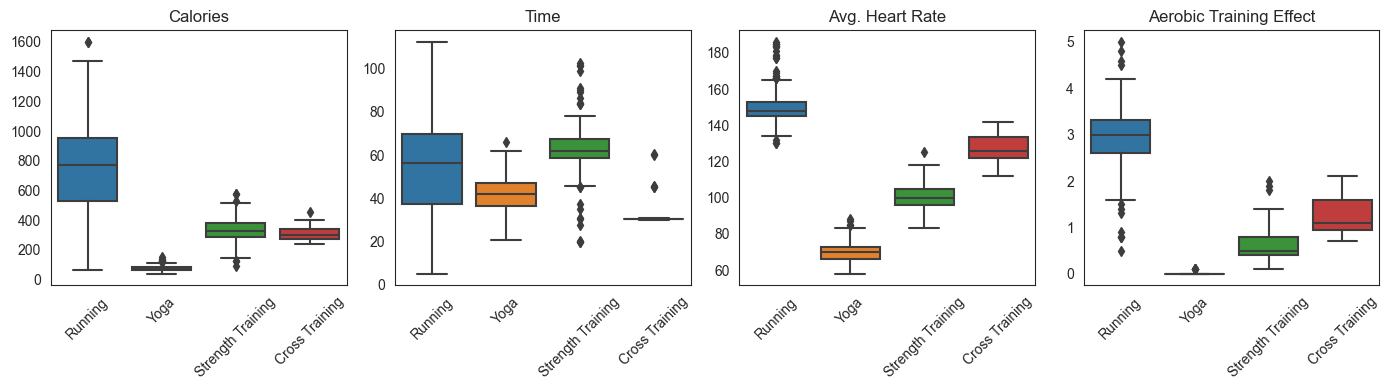

In [11]:
# Select the features to be used in the Anova Analysis
selected_features = ['Calories', 'Time', 'Avg_heart_rate', 'Aerobic_training_effect']

# Create a boxplot for each feature
fig, axs = plt.subplots(ncols=len(selected_features), figsize=(14, 4), tight_layout=True)
for i, feature in enumerate(selected_features):
    sns.boxplot(data=data, x='Activity', y=feature, ax=axs[i])
    axs[i].set(xlabel='', ylabel='', title=feature)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)
    if feature == 'Avg_heart_rate':
        axs[i].set(title='Avg. Heart Rate')
    if feature == 'Aerobic_training_effect':
        axs[i].set(title='Aerobic Training Effect')
fig.show()

In [12]:
# Perform an Anova Analysis on Kalorien based on type of activity
model = api.ols(formula='Calories ~ C(Activity)', data=data).fit()
anova = sm.stats.anova.anova_lm(model, typ=2)
anova

,sum_sq,df,F,PR(>F)
C(Activity),5.811938e+07,3.0,355.936846,6.897471e-138
Residual,3.624942e+07,666.0,NaN,NaN


In [13]:
# Perform an Anova Analysis on Zeit based on type of activity
model = api.ols(formula='Time ~ C(Activity)', data=data).fit()
anova = sm.stats.anova.anova_lm(model, typ=2)
anova

,sum_sq,df,F,PR(>F)
C(Activity),43173.857032,3.0,44.442503,3.451826e-26
Residual,215662.838840,666.0,NaN,NaN


In [14]:
# Perform an Anova Analysis on Avg_Herzfrequenz based on type of activity
model = api.ols(formula='Avg_heart_rate ~ C(Activity)', data=data).fit()
anova = sm.stats.anova.anova_lm(model, typ=2)
anova

,sum_sq,df,F,PR(>F)
C(Activity),797934.523613,3.0,4517.781263,0.0
Residual,39033.215518,663.0,NaN,NaN


In [15]:
# Perform an Anova Analysis on Aerober_TE based on type of activity
model = api.ols(formula='Aerobic_training_effect ~ C(Activity)', data=data).fit()
anova = sm.stats.anova.anova_lm(model, typ=2)
anova

,sum_sq,df,F,PR(>F)
C(Activity),1196.461300,3.0,1741.074254,8.283084e-314
Residual,151.870574,663.0,NaN,NaN


## Question 3: How can running activities be clustered?

In order to address this question, a [cluster analysis](https://sustainabilitymethods.org/index.php/Clustering_Methods) is conducted that reveals how the groups differ in performance parameters. Since many of the input features which are relevant for the clustering of running sessions show correlations in additional exploratory data analyses, e.g. distance, time and calories, a [PCA](https://sustainabilitymethods.org/index.php/Principal_Component_Analysis) is performed prior to the cluster analysis. Thus, the principal components (PC) which are free of redundancies can be used as input features for the cluster analysis.

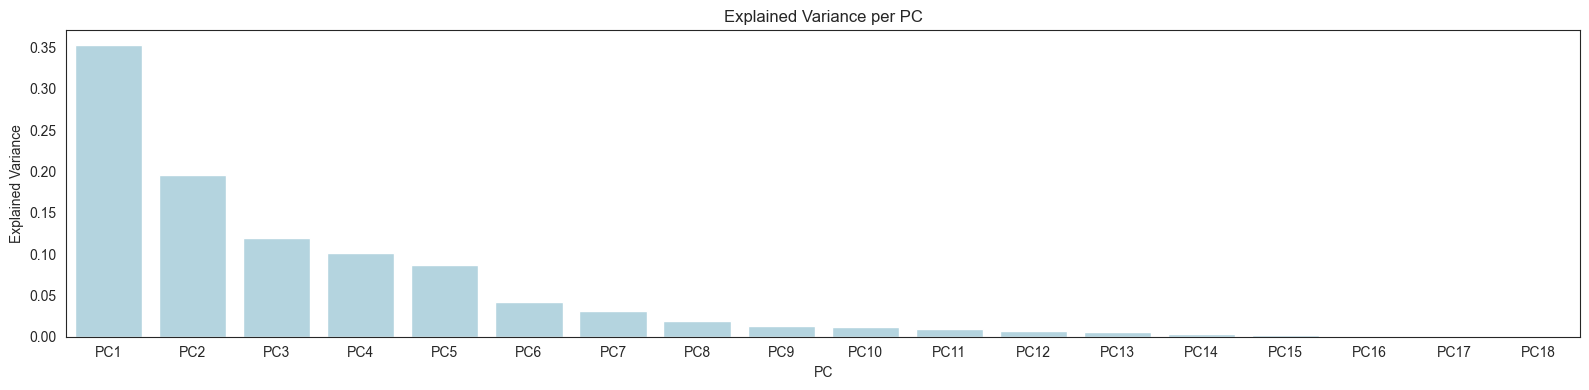

In [16]:
# Apply a PCA on the running data
pca = PCA(n_components=len(running_data.columns))
running_pcs = pd.DataFrame(pca.fit_transform(running_data_std), columns=[f'PC_{i + 1}' for i in range(pca.n_components_)],
                           index=running_data.index)

# Plot the explained variance per PC
fig, ax = plt.subplots(figsize=(16, 4), tight_layout=True)
sns.barplot(x=[f'PC{i+1}' for i in range(pca.n_components_)], y=pca.explained_variance_ratio_, color='lightblue', ax=ax)
ax.set(title='Explained Variance per PC', xlabel='PC', ylabel='Explained Variance')
fig.show()

The PCA shows substantial drops in explained variance after the first, second, and fifth PC indicating that the inclusion of the most relevant one, two or five PCs in a model might be reasonable choices. PC1 explains approximately 35%, PC1 and PC2 approximately 55% and PC1-PC5 approximately 85% of the variance in the data. We decided to use PC1 and PC2 as input features for the cluster analysis.

In order to perform cluster analysis, k-means method is applied. Since the solution of k-means clustering is not always optimal and depends on the initialization of cluster means, assignments of datapoints are performed ten times based on randomly chosen initializations from which the best one is chosen. 

At first, the optimal number of clusters is determined. This is done by computing clustering solutions for 1 to 15 clusters and comparing the results based on inertia and silhouette scores. Inertia is a commonly used metric measuring the heterogeneity inside of clusters. The silhouette score is a measure taking the heterogeneity inside and between clusters into account (see further readings). After determining an adequate number of clusters, the final cluster assignment is calculated and described.

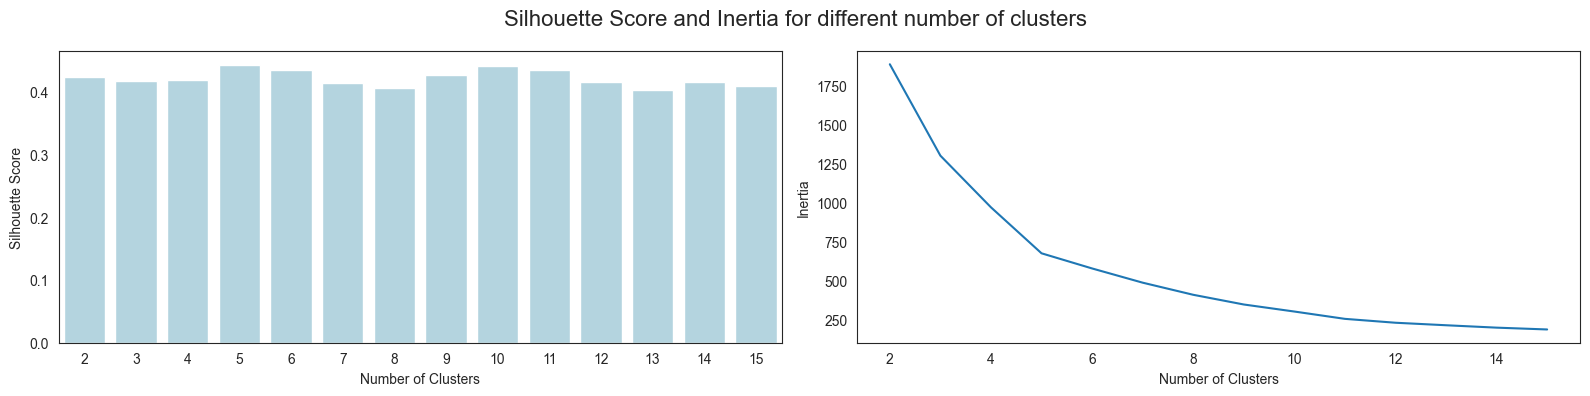

In [17]:
# Check the scores for different number of clusters to find the optimal number
silhouette_scores = []
inertias = []
for i in range(2, 16):
    cluster_model = KMeans(n_clusters=i, random_state=42, n_init=10)
    cluster = cluster_model.fit_predict(running_pcs[['PC_1', 'PC_2']])
    silhouette_scores.append(silhouette_score(running_pcs[['PC_1', 'PC_2']], cluster))
    inertias.append(cluster_model.inertia_)

scores = pd.DataFrame({'Silhouette Score': silhouette_scores, 'Inertia': inertias},
                      index=range(2, 16))

fig, axs = plt.subplots(1, 2, figsize=(16, 4), tight_layout=True)
fig.suptitle('Silhouette Score and Inertia for different number of clusters', fontsize=16)
sns.barplot(data=scores, x=scores.index, y='Silhouette Score', ax=axs[0], color='lightblue')
sns.lineplot(data=scores, x=scores.index, y='Inertia', ax=axs[1])
axs[0].set(title='', xlabel='Number of Clusters', ylabel='Silhouette Score')
axs[1].set(title='', xlabel='Number of Clusters', ylabel='Inertia')
fig.show()

Inertia and silhouette scores indicate that a 5-cluster-solution would ensure low heterogeneity inside and high heterogeneity between clusters so that the final assignment is performed with five clusters.

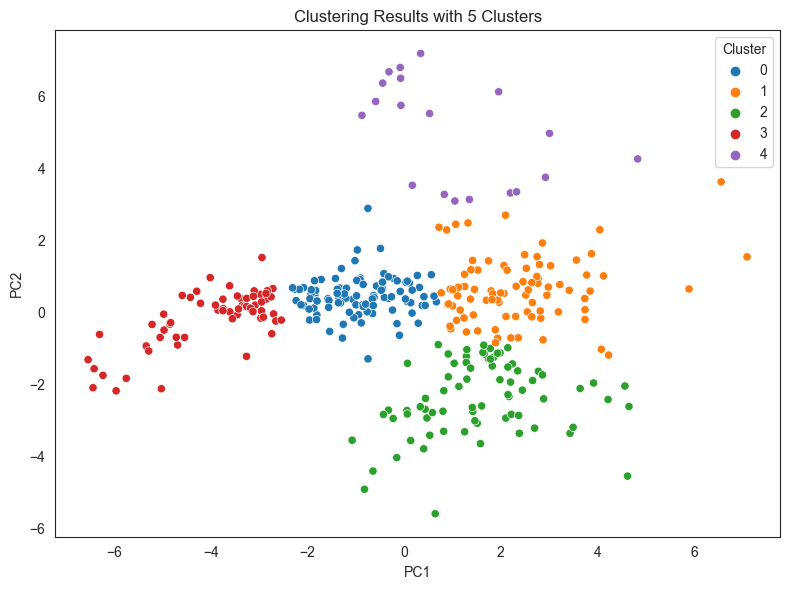

In [18]:
# Apply KMeans to the PCs with 5 clusters
cluster_model = KMeans(n_clusters=5, random_state=42, n_init=10)
cluster = cluster_model.fit_predict(running_pcs[['PC_1', 'PC_2']])

fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)
sns.scatterplot(data=running_pcs, x='PC_1', y='PC_2', hue=cluster.astype(str), ax=ax,
                hue_order=['0', '1', '2', '3', '4'])
ax.set(title='Clustering Results with 5 Clusters', xlabel='PC1', ylabel='PC2')
ax.legend().set_title('Cluster')
fig.show()

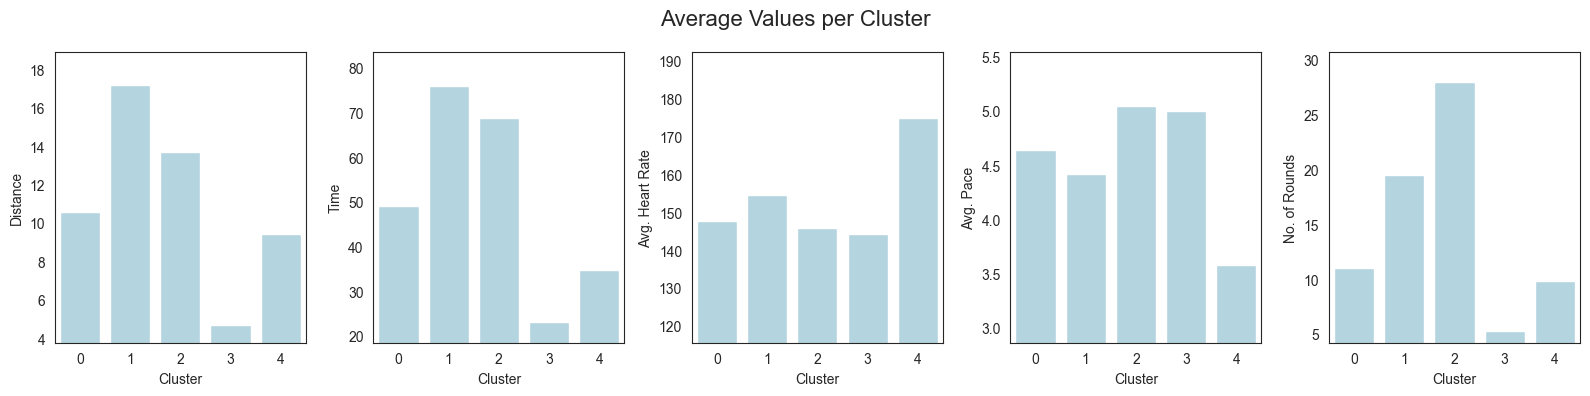

In [19]:
# Combine the cluster labels with the original data and plot the average values per cluster
running_data['Cluster'] = cluster
values = running_data.groupby('Cluster').mean()[['Distanz', 'Zeit', 'Avg_Herzfrequenz','Avg_Pace', 'Anzahl_der_Runden']].reset_index()
values = pd.melt(values, id_vars='Cluster', value_vars=['Distanz', 'Zeit', 'Avg_Herzfrequenz','Avg_Pace', 'Anzahl_der_Runden'], var_name='Metric', value_name='Value')

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(16, 4), tight_layout=True)
fig.suptitle('Average Values per Cluster', fontsize=16)
for i, metric in enumerate(['Distanz', 'Zeit', 'Avg_Herzfrequenz','Avg_Pace', 'Anzahl_der_Runden']):
    sns.barplot(data=values[values.Metric == metric], x='Cluster', y='Value', ax=ax[i], color='lightblue')
    ax[i].set(xlabel='Cluster', ylabel=metric, ylim=(values[values.Metric == metric].Value.min() * 0.8, values[values.Metric == metric].Value.max() * 1.1))
    if metric == 'Distanz':
        ax[i].set(ylabel='Distance')
    if metric == 'Avg_Herzfrequenz':
        ax[i].set(ylabel='Avg. Heart Rate')
    if metric == 'Zeit':
        ax[i].set(ylabel='Time')
    if metric == 'Avg_Pace':
        ax[i].set(ylabel='Avg. Pace')
    if metric == 'Anzahl_der_Runden':
        ax[i].set(ylabel='No. of Rounds')
fig.show()

# Drop the cluster column again
running_data.drop(columns=['Cluster'], inplace=True)

The final clusters are described by the variables distance, time, average heart frequency, average pace and number of rounds. All selected descriptive variables are easy to observe during a training session so that the athlete could relate them to a certain training behaviour. In this way, the clusters could be assigned to the following interpretable short descriptions:
- Cluster 0: Standard runs with medium pace and medium heart rate
- Cluster 1: Long runs with medium pace and medium heart rate
- Cluster 2: Intervall Sessions with high number of rounds
- Cluster 3: Short recovery runs with low pace and low heart rate
- Cluster 4: High intensity runs with high pace and high heart rate

## Question 4: How is the aerobic training effect explained by other training parameters?

As described above, the ATE is one of the key parameters of interest to running athletes. GLMs are employed to predict this effect as accurately as possible. To gather first insights into which parameters best approximate ATE, scatterplots using one feature against the ATE are generated. Below, two plots employing average heart rates are presented depicting the different types of activity and duration of the training sessions respectively.

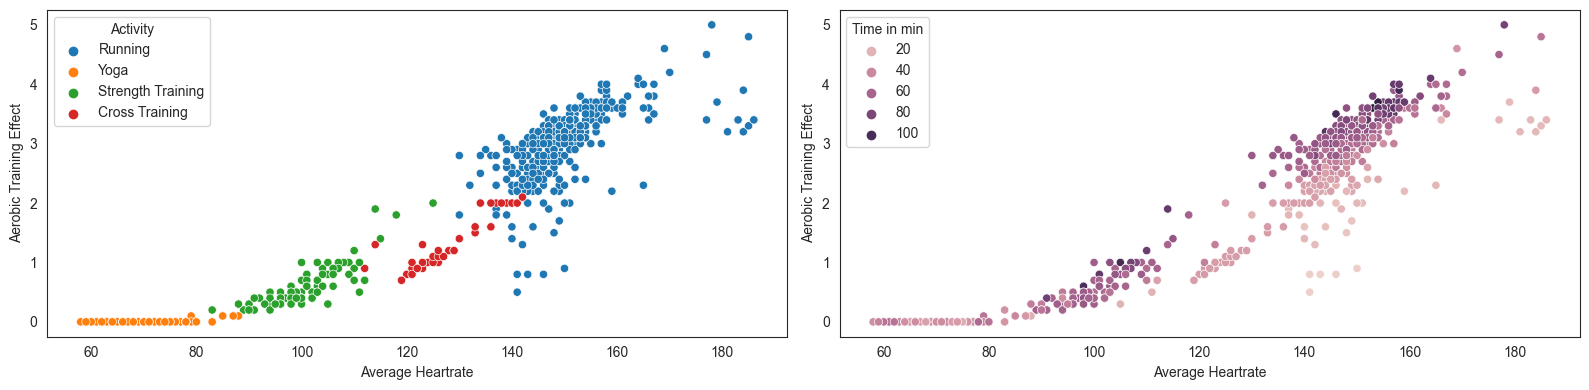

In [20]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 4), tight_layout=True)
sns.scatterplot(data=data, x='Avg_heart_rate', y='Aerobic_training_effect', hue='Activity', ax=axs[0])
axs[0].set(xlabel='Average Heartrate', ylabel='Aerobic Training Effect')
sns.scatterplot(data=data, x='Avg_heart_rate', y='Aerobic_training_effect', hue='Time', ax=axs[1])
axs[1].set(xlabel='Average Heartrate', ylabel='Aerobic Training Effect')
axs[1].legend().set_title('Time in min')
fig.show()

Yoga has no ATE and does not increase the athlete’s heart rate. In contrast, running, cross and strength training generate an ATE and raise the heart rate. While for cross and strength training, the plot indicates a relatively linear relation between heart rate and ATE, the data displays a higher variance for running activities. The right plot shows that the ATE increases proportionately with the duration of training. Due to the high correlations, average heart rate and time (duration) are included in all hypothesis models for GLMs below.

The dataset includes various positive continuous, discrete, and interval data with different distributions assumed, which is why [GLMs](https://sustainabilitymethods.org/index.php/Generalized_Linear_Models) are applied. This method uses a link function that relates a linear predictor and the assumed probability distribution of the observed variable to predict dependent variables with non-linear relations to the exogeneous, discrete targets, or diverse variance. Poisson probability distribution is used because ATE is a positive, discrete measure. (cf. further readings)

First, a full model is generated on the standardized training data.
Hereafter, degrees of freedom (DoF) are reduced iteratively to minimize the risk of overfitting while maintaining as much predictive power as possible, following [Occam’s razor](https://sustainabilitymethods.org/index.php/Why_statistics_matters#Occam.27s_razor). Hence, the models are compared with Akaike Information Criterion (AIC), which incorporates explanatory power and DoF.

To reduce multicollinearity, parameters with correlation coefficients beyond 0.9 are excluded based on a correlation heatmap. Subsequently, the parameters with the highest variance inflation factor (VIF) are dropped iteratively, until all coefficients are below the conventional threshold of 10. (cf. [Model reduction](https://sustainabilitymethods.org/index.php/Model_reduction))


### Full Model including all features

In [21]:
def calc_consistent_aic(model_results):
    consistent_aic = -2 * model_results.llf + model_results.df_model * np.log(running_data_std.shape[0]+1)
    return consistent_aic

In [22]:
# GLM using statsmodels library including all features
model_full = sm.api.GLM(endog=running_data_std['Aerobic_training_effect'],
                        exog=running_data_std.drop('Aerobic_training_effect', axis=1),
                        family=sm.api.families.Poisson())
results_full_model = model_full.fit()
print(results_full_model.summary())
print(f'AIC: {results_full_model.aic}')
print(f'Consistent AIC: {calc_consistent_aic(results_full_model)}')

                    Generalized Linear Model Regression Results                    
Dep. Variable:     Aerobic_training_effect   No. Observations:                  341
Model:                                 GLM   Df Residuals:                      324
Model Family:                      Poisson   Df Model:                           16
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -320.82
Date:                     Fri, 10 Mar 2023   Deviance:                       10285.
Time:                             22:07:43   Pearson chi2:                 4.41e+04
No. Iterations:                          8   Pseudo R-squ. (CS):                nan
Covariance Type:                 nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

### Reduced Model using stepwise reduction


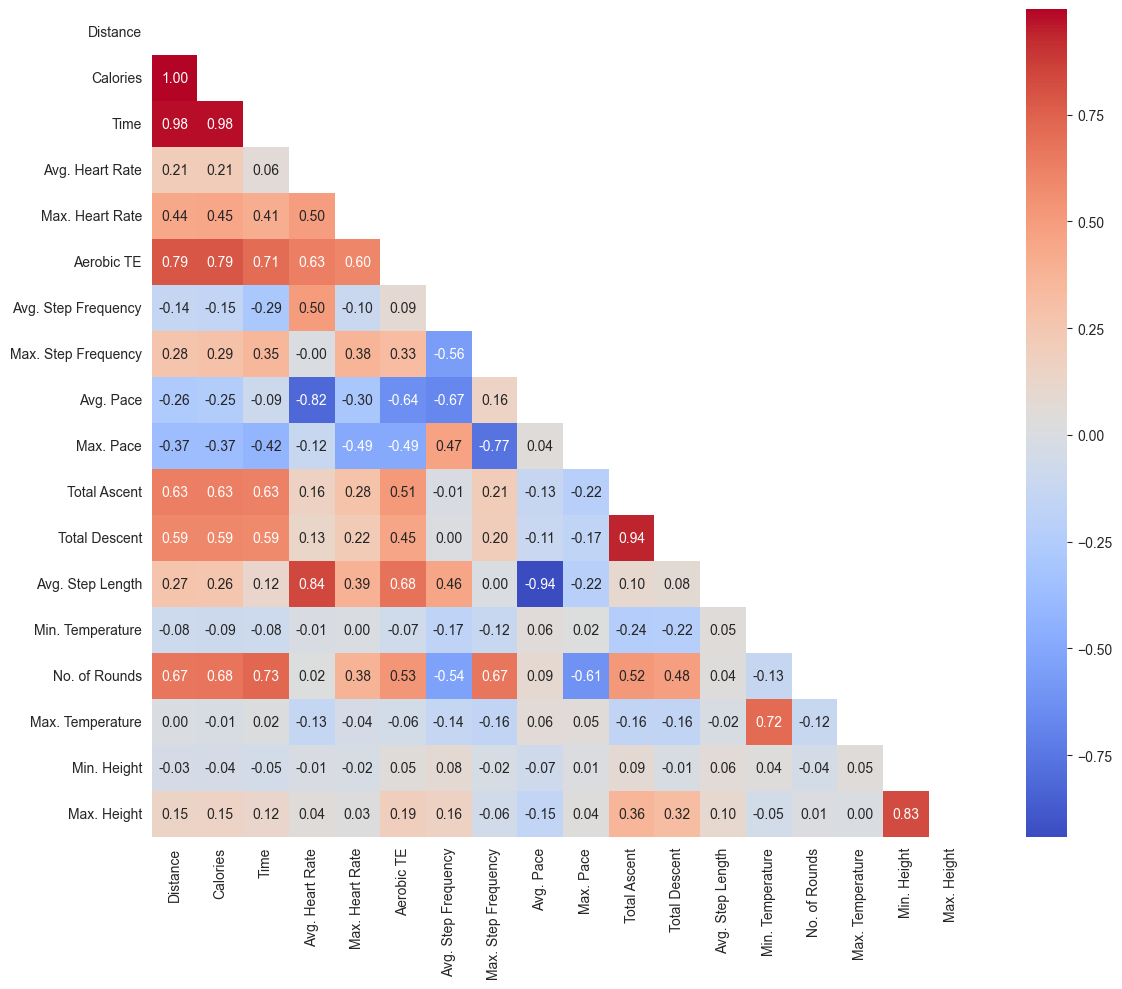

In [23]:
# Plot a heatmap of the correlations
corr = running_data.corr()
mask = np.triu(corr)
fig, ax = plt.subplots(figsize=(12, 10), tight_layout=True)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', mask=mask, ax=ax)
# translate features to English
ax.set_xticklabels(replace_xtick_labels(ax.get_xticklabels()))
ax.set_yticklabels(replace_xtick_labels(ax.get_yticklabels()))

fig.show()

In [24]:
def calculate_vif(input_df):
    vif = pd.DataFrame()
    vif['VIF Factor'] = [variance_inflation_factor(input_df.values, col) for col in range(len(input_df.columns))]
    vif['features'] = input_df.columns
    return vif

In [25]:
running_data_after_vifs = running_data_std.drop(['Aerobic_training_effect', 'Calories', 'Time', 'Avg_Step_Length', 'Total_Descent'], axis=1)
calculate_vif(running_data_after_vifs).sort_values('VIF Factor', ascending=False)

,VIF Factor,features
5,6.496549,Avg_Pace
3,5.190501,Avg_Step_Frequency
12,4.904805,Max_Height
1,4.818190,Avg_heart_rate
9,4.585780,No_of_Rounds
11,4.112934,Min_Height
4,3.477695,Max_Step_Frequency
0,3.370108,Distance
6,3.295303,Max_Pace
7,2.636315,Total_Ascent


In [26]:
# GLM with features excluded based on correlation coefficient and VIF
model_VIF_reduced = sm.api.GLM(endog=running_data_std['Aerobic_training_effect'],
                           exog=running_data_std.drop(['Aerobic_training_effect', 'Calories', 'Time', 'Avg_Step_Length', 'Total_Descent'], axis=1),
                           family=sm.api.families.Poisson())
results_VIF_reduced_model = model_VIF_reduced.fit()
print(results_VIF_reduced_model.summary())
print(f'AIC: {results_VIF_reduced_model.aic}')
print(f'Consistent AIC: {calc_consistent_aic(results_VIF_reduced_model)}')

                    Generalized Linear Model Regression Results                    
Dep. Variable:     Aerobic_training_effect   No. Observations:                  341
Model:                                 GLM   Df Residuals:                      328
Model Family:                      Poisson   Df Model:                           12
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -349.49
Date:                     Fri, 10 Mar 2023   Deviance:                       10178.
Time:                             22:07:45   Pearson chi2:                 3.40e+03
No. Iterations:                          7   Pseudo R-squ. (CS):                nan
Covariance Type:                 nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

The athlete’s domain knowledge and correlation considerations are used to construct four model hypotheses for predicting ATE:

The first model includes few parameters that are controllable for the athlete, namely, distance, duration, pace and average heart rate of the run. 

The second model additionally uses the environmental factors maximum temperature and total ascent.

The third model contains all features for which the absolute correlation coefficient with respect to ATE is above 0.5. Calories are exempted as they are not measured but calculated based on other parameters, thus, exhibiting very high multicollinearity. 

A fourth, minimal model only includes the average heart rates and running times. 

Furthermore, GLMs including the first two, five, and all principal components were considered. They are eliminated of multicollinearity and, thus, expected to achieve highest predictive power. 

In [27]:
# 1. model with few internal factors
model_1 = sm.api.GLM(endog=running_data_std['Aerobic_training_effect'],
                     exog=running_data_std[['Distance', 'Time', 'Avg_heart_rate', 'Avg_Pace']],
                     family=sm.api.families.Poisson())
results_model_1 = model_1.fit()
print(results_model_1.summary())
print(f'AIC: {results_model_1.aic}')
print(f'Consistent AIC: {calc_consistent_aic(results_model_1)}')

                    Generalized Linear Model Regression Results                    
Dep. Variable:     Aerobic_training_effect   No. Observations:                  341
Model:                                 GLM   Df Residuals:                      337
Model Family:                      Poisson   Df Model:                            3
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -354.19
Date:                     Fri, 10 Mar 2023   Deviance:                       10202.
Time:                             22:07:45   Pearson chi2:                 4.20e+03
No. Iterations:                          8   Pseudo R-squ. (CS):                nan
Covariance Type:                 nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

In [28]:
# 2. model additionally including environmental factors
model_2 = sm.api.GLM(endog=running_data_std['Aerobic_training_effect'],
                     exog=running_data_std[['Distance', 'Time', 'Avg_heart_rate', 'Avg_Pace', 'Max_Temperature', 'Total_Ascent']],
                     family=sm.api.families.Poisson())
results_model_2 = model_2.fit()
print(results_model_2.summary())
print(f'AIC: {results_model_2.aic}')
print(f'Consistent AIC: {calc_consistent_aic(results_model_2)}')

                    Generalized Linear Model Regression Results                    
Dep. Variable:     Aerobic_training_effect   No. Observations:                  341
Model:                                 GLM   Df Residuals:                      335
Model Family:                      Poisson   Df Model:                            5
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -353.65
Date:                     Fri, 10 Mar 2023   Deviance:                       10204.
Time:                             22:07:45   Pearson chi2:                 4.32e+03
No. Iterations:                          8   Pseudo R-squ. (CS):                nan
Covariance Type:                 nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

In [29]:
# 3. model including features with highest corr. coefficients
model_3 = sm.api.GLM(endog=running_data_std['Aerobic_training_effect'],
                     exog=running_data_std[['Distance', 'Time', 'Avg_heart_rate', 'Max_Heart_Rate', 'Avg_Pace', 'Avg_Step_Length', 'Total_Ascent', 'No_of_Rounds']],
                     family=sm.api.families.Poisson())
results_model_3 = model_3.fit()
print(results_model_3.summary())
print(f'AIC: {results_model_3.aic}')
print(f'Consistent AIC: {calc_consistent_aic(results_model_3)}')

                    Generalized Linear Model Regression Results                    
Dep. Variable:     Aerobic_training_effect   No. Observations:                  341
Model:                                 GLM   Df Residuals:                      333
Model Family:                      Poisson   Df Model:                            7
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -348.29
Date:                     Fri, 10 Mar 2023   Deviance:                       10216.
Time:                             22:07:45   Pearson chi2:                 5.78e+03
No. Iterations:                          7   Pseudo R-squ. (CS):                nan
Covariance Type:                 nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

In [30]:
# 4. minimal model
model_4 = sm.api.GLM(endog=running_data_std['Aerobic_training_effect'],
                     exog=running_data_std[['Avg_heart_rate', 'Time']],
                     family=sm.api.families.Poisson())
results_model_4 = model_4.fit()
print(results_model_4.summary())
print(f'AIC: {results_model_4.aic}')
print(f'Consistent AIC: {calc_consistent_aic(results_model_4)}')

                    Generalized Linear Model Regression Results                    
Dep. Variable:     Aerobic_training_effect   No. Observations:                  341
Model:                                 GLM   Df Residuals:                      339
Model Family:                      Poisson   Df Model:                            1
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -385.65
Date:                     Fri, 10 Mar 2023   Deviance:                       10111.
Time:                             22:07:45   Pearson chi2:                 1.16e+03
No. Iterations:                          7   Pseudo R-squ. (CS):                nan
Covariance Type:                 nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

In [31]:
# 5. model: PC1, PC2
model_5 = sm.api.GLM(endog=running_data_std['Aerobic_training_effect'],
                     exog=running_pcs[['PC_1', 'PC_2']],
                     family=sm.api.families.Poisson())
results_model_5 = model_5.fit()
print(results_model_5.summary())
print(f'AIC: {results_model_5.aic}')
print(f'Consistent AIC: {calc_consistent_aic(results_model_5)}')

                    Generalized Linear Model Regression Results                    
Dep. Variable:     Aerobic_training_effect   No. Observations:                  341
Model:                                 GLM   Df Residuals:                      339
Model Family:                      Poisson   Df Model:                            1
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -374.08
Date:                     Fri, 10 Mar 2023   Deviance:                       10121.
Time:                             22:07:45   Pearson chi2:                 1.42e+03
No. Iterations:                          7   Pseudo R-squ. (CS):                nan
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PC

In [32]:
# 6. model: PC1, PC2, PC3, PC4, PC5
model_6 = sm.api.GLM(endog=running_data_std['Aerobic_training_effect'],
                     exog=running_pcs[['PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5']],
                     family=sm.api.families.Poisson())
results_model_6 = model_6.fit()
print(results_model_6.summary())
print(f'AIC: {results_model_6.aic}')
print(f'Consistent AIC: {calc_consistent_aic(results_model_6)}')

                    Generalized Linear Model Regression Results                    
Dep. Variable:     Aerobic_training_effect   No. Observations:                  341
Model:                                 GLM   Df Residuals:                      336
Model Family:                      Poisson   Df Model:                            4
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -363.39
Date:                     Fri, 10 Mar 2023   Deviance:                       10130.
Time:                             22:07:45   Pearson chi2:                 1.61e+03
No. Iterations:                          7   Pseudo R-squ. (CS):                nan
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PC

In [33]:
# 7. model: all principal components
model_7 = sm.api.GLM(endog=running_data_std['Aerobic_training_effect'],
                     exog=running_pcs[[f'PC_{i+1}' for i in range(pca.n_components_)]],
                     family=sm.api.families.Poisson())
results_model_7 = model_7.fit()
print(results_model_7.summary())
print(f'AIC: {results_model_7.aic}')
print(f'Consistent AIC: {calc_consistent_aic(results_model_7)}')

                    Generalized Linear Model Regression Results                    
Dep. Variable:     Aerobic_training_effect   No. Observations:                  341
Model:                                 GLM   Df Residuals:                      323
Model Family:                      Poisson   Df Model:                           17
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -298.49
Date:                     Fri, 10 Mar 2023   Deviance:                       10303.
Time:                             22:07:45   Pearson chi2:                 1.50e+05
No. Iterations:                          8   Pseudo R-squ. (CS):                nan
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PC

Based on the AIC, the full PC model achieves the best performance, followed by the full model, and hypothesis model containing the features with highest correlation coefficients with respect to ATE.

The good performance of the full model suggests that the AIC may not sufficiently punish the number of features. To overcome this limitation, Bozdogan (1987) proposes the Consistent AIC (CAIC) for model selection. CAIC “increases the ‘penalty term’” (p. 358), thus leading to generally lower dimensional models to avoid overfitting. 

Based on the manually calculated CAIC, the full PC model achieves the best performance but, in contrast to the previous findings, the model with few, controllable factors outperforms the full model. Adding the environmental factors worsens the performance to the level of the full model, which also applies to the model containing only the features with the highest ATE-correlation coefficients. Still, the minimal model performs worst.

Thus, the model selection based on Poisson regression and CAIC suggests that the best ATE predictors are *distance, time, average heart rate, and average pace*.  

## Conclusion
To analyze the training data of a track athlete, this report uses exploratory data analysis, one-way-anova, pca, clustering and model selection for GLM. Based on the research questions, this analysis yields the following results:

- Question 1: The majority of trainings was performed in the late afternoon. The monthly kilometers are consistent over the year, but dropped in September. The weekly distribution show increasing training loads paired with recovery weeks.
- Question 2: The training types differ significantly in calories, average heart rate and ATE. Running activities exhibit the highest mean value but also the highest variations.
- Question 3: Running activities could be divided into five different groups with respective characteristics and impact on the training load.
- Question 4: The best hypothesis based on CAIC contains the features distance, time, average heart rate and average pace. However, the best performance is achieved by the full PC model.

Overall, the insights generated through this statistical analysis may serve to assist athletes in their race preparation.

> *We run together <br>
Cardiac arrest times three <br>
Performance is peak*

## Referencs and further readings
- Inertia and silhouette score: https://towardsdatascience.com/silhouette-or-elbow-that-is-the-question-a1dda4fb974
- GLM: https://towardsdatascience.com/generalized-linear-models-9cbf848bb8ab, 
- GLM: https://www.researchgate.net/publication/235726158
- AIC and CAIC: Bozdogan, H. (1987). Model selection and Akaike's Information Criterion (AIC): The general theory and its analytical extensions. Psychometrika 52, 345–370. https://doi.org/10.1007/BF02294361
- Schwäbischer Haiku: https://www.topster.de/deutsch-schwaebisch/